/var/folders/6d/n0c7d2jd30sb50l09f4d_qsm0000gn/T/ipykernel_12646/1517103223.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


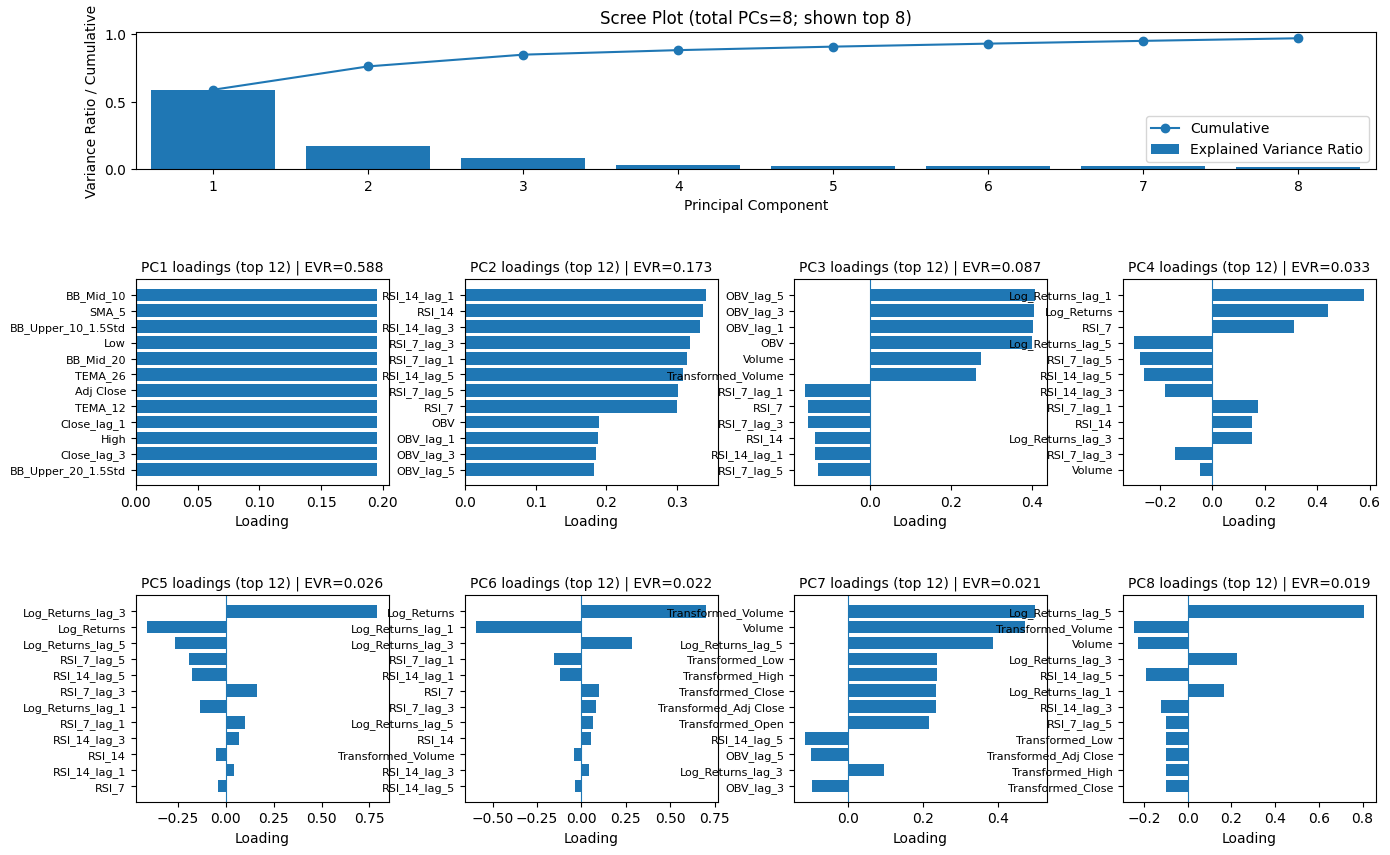

In [ ]:
# --- LSTM PCA quick plots for Jupyter ---
import os, json
import numpy as np
import matplotlib.pyplot as plt
from joblib import load as joblib_load

META_PATH = "data/processed_folds/final/models/lstm_final_models_meta.json"
PCA_PATH  = "data/processed_folds/final/models/lstm_final_pca.pkl"


K_SHOW  = 8      
TOPN    = 12    
N_COLS  = 4      
FIG_W   = 16
FIG_H   = 10

# ---------- Load meta & PCA ----------
with open(META_PATH, "r") as f:
    meta = json.load(f)

feature_cols = meta.get("feature_cols", [])
pca_info = meta.get("pca", {})
evr = pca_info.get("explained_variance_ratio", None)
reduced_dim = int(pca_info.get("reduced_dim", 0) or 0)

pca = joblib_load(PCA_PATH)
components = np.asarray(pca.components_, dtype=float)  # (n_components, n_features)


if evr is None and hasattr(pca, "explained_variance_ratio_"):
    evr = pca.explained_variance_ratio_.tolist()
evr = np.array(evr, dtype=float) if evr is not None else np.ones(components.shape[0]) / components.shape[0]


n_pc = int(min(K_SHOW, components.shape[0], len(evr)))
n_features = components.shape[1]
if len(feature_cols) != n_features:
    feature_cols = [f"F{i+1}" for i in range(n_features)] 


grid_cols = int(N_COLS)
grid_rows = int(np.ceil(n_pc / grid_cols))
total_rows = 1 + grid_rows

fig = plt.figure(figsize=(FIG_W, FIG_H))
gs = fig.add_gridspec(total_rows, grid_cols, height_ratios=[1.0] + [1.5]*grid_rows, hspace=0.6, wspace=0.3)

ax0 = fig.add_subplot(gs[0, :])
x_idx = np.arange(1, len(evr)+1)
ax0.bar(x_idx, evr, label="Explained Variance Ratio")
ax0.plot(x_idx, np.cumsum(evr), marker="o", linewidth=1.5, label="Cumulative")
ax0.set_xlim(0.5, len(evr) + 0.5)
ax0.set_xlabel("Principal Component")
ax0.set_ylabel("Variance Ratio / Cumulative")
ax0.set_title(f"Scree Plot (total PCs={len(evr)}; shown top {n_pc})")
ax0.legend(loc="best")


for i in range(n_pc):
    r = 1 + (i // grid_cols)
    c = i % grid_cols
    ax = fig.add_subplot(gs[r, c])

    loadings = components[i]
    idx = np.argsort(np.abs(loadings))[::-1][:TOPN]
    names = [feature_cols[j] for j in idx]
    vals  = loadings[idx]

    order = np.argsort(np.abs(vals))[::-1]
    names = [names[j] for j in order]
    vals  = vals[order]

    ax.barh(range(len(vals)), vals)
    ax.set_yticks(range(len(vals)))
    ax.set_yticklabels(names, fontsize=8)
    ax.invert_yaxis()
    title = f"PC{i+1} loadings (top {len(vals)}) | EVR={evr[i]:.3f}" if i < len(evr) else f"PC{i+1} loadings"
    ax.set_title(title, fontsize=10)
    ax.axvline(0.0, linewidth=0.8)
    ax.set_xlabel("Loading")

plt.tight_layout()
plt.show()

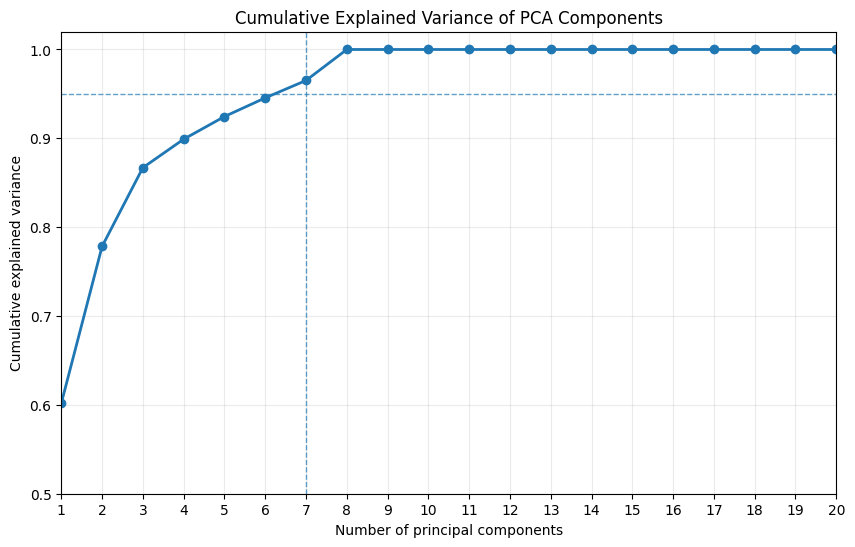

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from joblib import load as joblib_load

# ---- Paths ----
META_PATH = "data/processed_folds/final/models/lstm_final_models_meta.json"
PCA_PATH  = "data/processed_folds/final/models/lstm_final_pca.pkl"

THRESHOLD = 0.95

# ---- Load meta + PCA ----
with open(META_PATH, "r") as f:
    meta = json.load(f)
pca = joblib_load(PCA_PATH)

if hasattr(pca, "explained_variance_ratio_"):
    evr = np.asarray(pca.explained_variance_ratio_, dtype=float)
else:
    evr = np.asarray(meta.get("pca", {}).get("explained_variance_ratio", []), dtype=float)

cev = np.cumsum(evr)
max_comp = 20
x = np.arange(1, max_comp + 1)
cev_padded = np.pad(cev, (0, max_comp - len(cev)), constant_values=1.0)

k_star = meta.get("pca", {}).get("reduced_dim", len(cev))

# ---- Plot ----
plt.figure(figsize=(10, 6))
plt.plot(
    x, cev_padded[:max_comp],
    linestyle='-',
    marker='o',
    linewidth=2,
    markersize=6,
    solid_capstyle='round'  
)

plt.axhline(THRESHOLD, linestyle="--", linewidth=1, alpha=0.7)
plt.axvline(k_star, linestyle="--", linewidth=1, alpha=0.7)

plt.title("Cumulative Explained Variance of PCA Components")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")

plt.ylim(0.5, 1.02)             
plt.xlim(1, max_comp)
plt.xticks(range(1, max_comp + 1))

plt.grid(alpha=0.25)
plt.show()

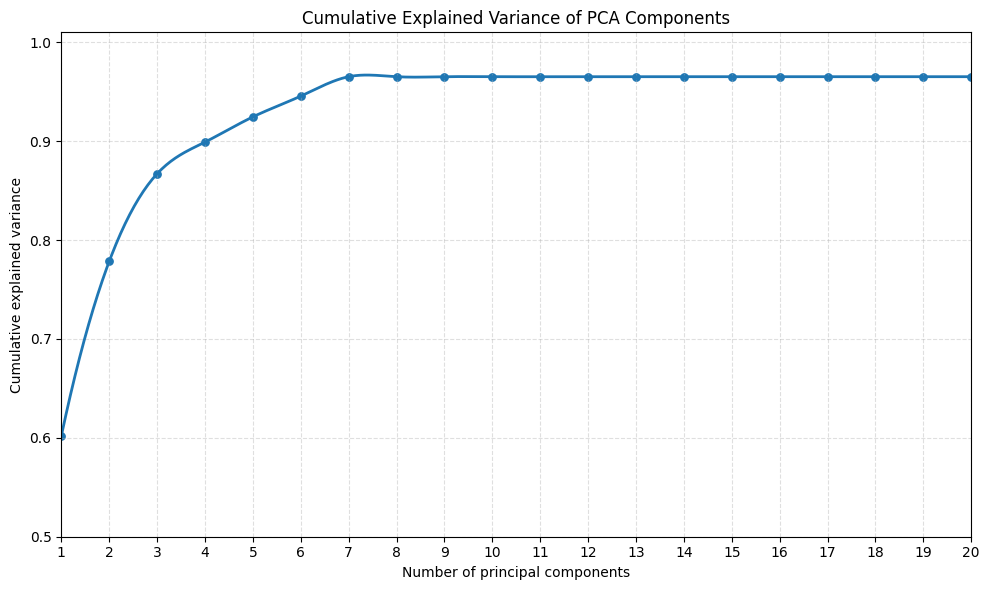

In [1]:
# Scree plot (cumulative explained variance) with optional spline smoothing
import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ---- path to meta json ----
meta_path = Path("data/processed_folds/final/models/lstm_final_models_meta.json")

# ---- load EVR from meta ----
with meta_path.open("r") as f:
    meta = json.load(f)

evr = meta.get("pca", {}).get("explained_variance_ratio", None)
if evr is None:
    raise ValueError("Không tìm thấy 'explained_variance_ratio' trong meta JSON.")

evr = np.asarray(evr, dtype=float)
cev = np.cumsum(evr)  # cumulative explained variance

# ---- pad/truncate to 20 components for consistent axis ----
max_components = 20
if len(cev) >= max_components:
    cev_plot = cev[:max_components]
else:
    last = cev[-1] if len(cev) else 0.0
    cev_plot = np.concatenate([cev, np.full(max_components - len(cev), last)])

x = np.arange(1, max_components + 1)

# ---- try spline smoothing; fallback to simple line if SciPy not available ----
use_spline = False
try:
    from scipy.interpolate import make_interp_spline
    X_dense = np.linspace(x.min(), x.max(), 400)
    Y_dense = make_interp_spline(x[:len(cev_plot)], cev_plot, k=3)(X_dense)
    use_spline = True
except Exception:
    pass  # no scipy, will plot simple line

plt.figure(figsize=(10, 6))

if use_spline:
    plt.plot(X_dense, Y_dense, linewidth=2)
    plt.scatter(x, cev_plot, s=28)  # show original points
else:
    plt.plot(x, cev_plot, marker='o', linewidth=2)

# axes & grid
plt.ylim(0.5, 1.01)
plt.xlim(1, max_components)
plt.xticks(np.arange(1, max_components + 1, 1))
plt.grid(True, linestyle="--", alpha=0.4)
plt.title("Cumulative Explained Variance of PCA Components")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")

plt.tight_layout()
plt.show()

LSTM architecture diagram (block schematic)

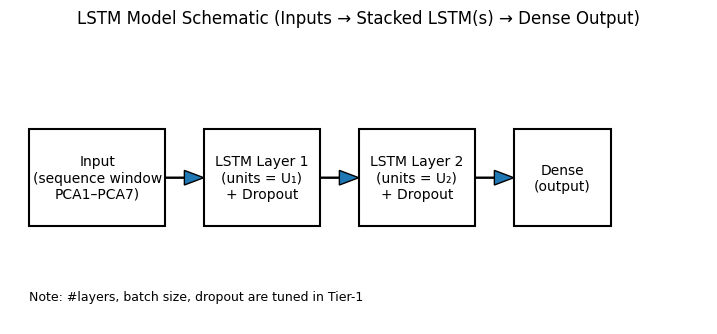

In [5]:
# === Figure Y: LSTM Architecture Diagram (schematic) ===
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow

fig, ax = plt.subplots(figsize=(9, 3.8))
ax.set_xlim(0, 18)
ax.set_ylim(0, 6)
ax.axis('off')

def box(x, y, w, h, text):
    rect = Rectangle((x, y), w, h, linewidth=1.5, fill=False)
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, text, ha='center', va='center')

def arrow(x1, y1, x2, y2):
    ax.add_patch(FancyArrow(x1, y1, x2-x1, y2-y1, width=0.02, length_includes_head=True, head_width=0.3, head_length=0.5))

# Blocks
box(0.5, 2.0, 3.5, 2.0, "Input\n(sequence window\nPCA1–PCA7)")
arrow(4.0, 3.0, 5.0, 3.0)

box(5.0, 2.0, 3.0, 2.0, "LSTM Layer 1\n(units = U₁)\n+ Dropout")
arrow(8.0, 3.0, 9.0, 3.0)

box(9.0, 2.0, 3.0, 2.0, "LSTM Layer 2\n(units = U₂)\n+ Dropout")
arrow(12.0, 3.0, 13.0, 3.0)

box(13.0, 2.0, 2.5, 2.0, "Dense\n(output)")
ax.text(0.5, 0.5, "Note: #layers, batch size, dropout are tuned in Tier-1", fontsize=9)

ax.set_title("LSTM Model Schematic (Inputs → Stacked LSTM(s) → Dense Output)")
plt.show()

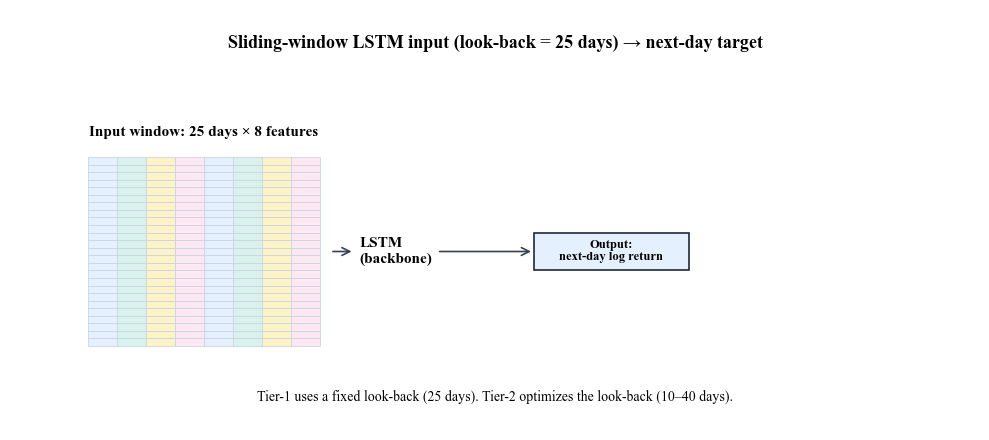

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

plt.rcParams["font.family"] = "Times New Roman"

def fig_sliding_window(window=25, n_features=8,
                       out="figure_sliding_window_lstm.png"):
    fig, ax = plt.subplots(figsize=(10, 4.5))
    ax.axis("off")

    # Title
    ax.text(0.5, 0.92,
            f"Sliding-window LSTM input (look-back = {window} days) → next-day target",
            ha="center", va="center", fontsize=13, weight="bold")

    # Input matrix
    x0, y0 = 0.08, 0.20
    cell_w, cell_h = 0.03, 0.018
    rows, cols = window, n_features
    base_colors = ["#e5f0ff", "#d9f2ee", "#fef3c7", "#fce7f3"]

    for r in range(rows):
        for c in range(cols):
            fc = base_colors[c % len(base_colors)]
            rect = Rectangle((x0 + c*cell_w, y0 + (rows-1-r)*cell_h),
                             cell_w, cell_h,
                             facecolor=fc, edgecolor="#cbd5e1", linewidth=0.6)
            ax.add_patch(rect)

    # Input label
    ax.text(x0 + cols*cell_w/2, y0 + rows*cell_h + 0.05,
            f"Input window: {window} days × {n_features} features",
            ha="center", fontsize=11, weight="bold")

    # Arrow to LSTM
    ax.add_patch(FancyArrowPatch(
        (x0 + cols*cell_w + 0.01, y0 + rows*cell_h/2),
        (x0 + cols*cell_w + 0.035, y0 + rows*cell_h/2),
        arrowstyle="->", mutation_scale=14, linewidth=1.2, color="#374151"
    ))
    ax.text(x0 + cols*cell_w + 0.04, y0 + rows*cell_h/2,
            "LSTM\n(backbone)", va="center", ha="left",
            fontsize=11, weight="bold")

    # Output block
    out_x = x0 + cols*cell_w + 0.22
    out_y = y0 + rows*cell_h/2 - 0.045
    out_w, out_h = 0.16, 0.09
    ax.add_patch(Rectangle((out_x, out_y), out_w, out_h,
                           facecolor="#e5f0ff", edgecolor="#1f2937", linewidth=1.2))
    ax.text(out_x + out_w/2, out_y + out_h/2,
            "Output:\nnext-day log return",
            ha="center", fontsize=9, va="center", weight="bold")

    # Arrow LSTM → output
    ax.add_patch(FancyArrowPatch(
        (x0 + cols*cell_w + 0.12, y0 + rows*cell_h/2),
        (out_x, out_y + out_h/2),
        arrowstyle="->", mutation_scale=14, linewidth=1.2, color="#374151"
    ))

    # Notes
    ax.text(0.5, 0.08,
            "Tier-1 uses a fixed look-back (25 days). Tier-2 optimizes the look-back (10–40 days).",
            ha="center", va="center")
    plt.tight_layout()
    plt.savefig(out, bbox_inches="tight", dpi=300)
    plt.show()

# Run example
fig_sliding_window()

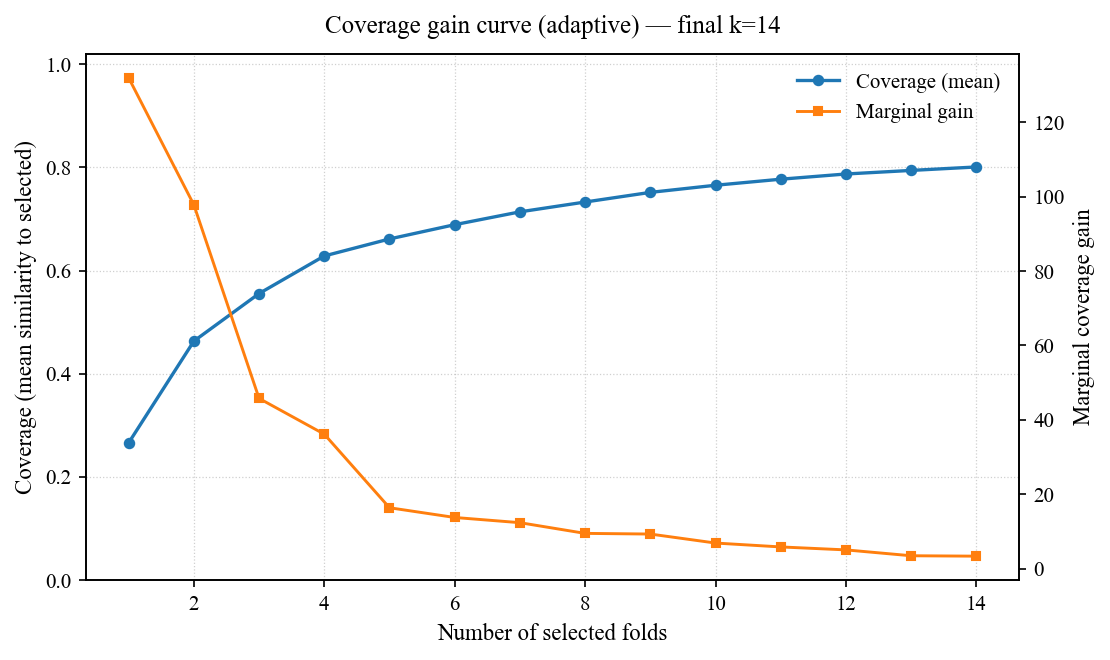

In [19]:
import json, os
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

RESULT_JSON = "data/processed_folds/lstm_meta/selected_lstm.json"  

def load_selection_result(path):
    with open(path, "r") as f:
        obj = json.load(f)
    if isinstance(obj, list):
        raise ValueError(
            "You loaded a LIST (likely tuning_folds_{model}.json); it has no coverage curves.\n"
            "Use the selection RESULT json (selected_{model}.json) that contains {'curves': {'coverage': [...], 'gain': [...]}}."
        )
    if not isinstance(obj, dict):
        raise ValueError("Unexpected JSON type. Expected dict with keys like 'curves', 'mode', 'k'.")
    return obj

res = load_selection_result(RESULT_JSON)

curves = res.get("curves", {})
coverage = curves.get("coverage", []) or res.get("coverage_curve", [])
gain     = curves.get("gain", [])     or res.get("gain_curve", [])

if not coverage:
    raise ValueError(
        "No coverage curve found. Ensure you ran select_representatives.py (not --eval_only) "
        "and saved the selection result (selected_{model}.json)."
    )

x = list(range(1, len(coverage)+1))
fig, ax1 = plt.subplots(figsize=(7.5, 4.5))
ln1 = ax1.plot(x, coverage, marker="o", linewidth=1.6, markersize=4.5,
               label="Coverage (mean)", color="#1f77b4")
ax1.set_xlabel("Number of selected folds", fontsize=11)
ax1.set_ylabel("Coverage (mean similarity to selected)", fontsize=11)
ax1.set_ylim(0, 1.02)
ax1.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

# Optional marginal gain
if gain and len(gain) == len(coverage):
    ax2 = ax1.twinx()
    ln2 = ax2.plot(x, gain, marker="s", linewidth=1.4, markersize=3.8,
                   label="Marginal gain", color="#ff7f0e")
    ax2.set_ylabel("Marginal coverage gain", fontsize=11)
    lines = ln1 + ln2
else:
    lines = ln1

labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, frameon=False, fontsize=10, loc="upper right")
title = res.get("mode", "coverage gain curve")
k = res.get("k")
plt.title(f"Coverage gain curve ({title})" + (f" — final k={k}" if k else ""), fontsize=12, pad=10)
plt.tight_layout()
plt.savefig("coverage_curve.png", bbox_inches="tight")
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("data/tuning_results/csv/tier2_lstm_knee.csv")

summary = (
    df.groupby("retrain_interval")
      .agg(
          median_sharpe=("sharpe", "median"),
          median_mdd=("mdd", "median"),
          median_turnover=("turnover", "median"),
          n_folds=("fold_id", "nunique")
      )
      .reset_index()
)

print(summary)

with open("table_lstm_knee_summary.tex", "w") as f:
    f.write(summary.to_latex(index=False, float_format="%.4f",
                             caption="Performance of knee solutions for LSTM models (median across folds)",
                             label="tab:lstm_knee_summary"))

   retrain_interval  median_sharpe  median_mdd  median_turnover  n_folds
0                10       5.288084    0.011869             12.5       14
1                20       5.948252    0.004636             10.0       14
2                42       5.849926    0.004267              9.0       14


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -------- paths --------
HV_CSV  = Path("data/tuning_results/csv/tier2_lstm_hv.csv")
OUT_PNG = Path("results/chap5/Fig_5_3_HV_progression_lstm_markers.png")
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)

# -------- style --------
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

# -------- load --------
hv = pd.read_csv(HV_CSV)

# keep GA logs per generation
ga_gen = hv[(hv["stage"] == "GA") & (hv["gen"] >= 1)].copy()

# aggregate mean ± std
agg = (ga_gen.groupby(["retrain_interval","gen"], as_index=False)
              .agg(hv_mean=("hv","mean"), hv_std=("hv","std")))
agg["hv_std"] = agg["hv_std"].fillna(0.0)

intervals = sorted(agg["retrain_interval"].unique())
colors = plt.cm.tab10.colors

# -------- plot --------
fig, ax = plt.subplots(figsize=(7.6, 4.6))

for i, interval in enumerate(intervals):
    sub = agg[agg["retrain_interval"] == interval].sort_values("gen")
    c = colors[i % len(colors)]
    ax.plot(sub["gen"], sub["hv_mean"], color=c, lw=2,
            label=f"GA (interval={interval})", zorder=3)
    ax.fill_between(sub["gen"],
                    sub["hv_mean"] - sub["hv_std"],
                    sub["hv_mean"] + sub["hv_std"],
                    color=c, alpha=0.18, linewidth=0, zorder=2)

# y-padding
ymin = float((agg["hv_mean"] - agg["hv_std"]).min())
ymax = float((agg["hv_mean"] + agg["hv_std"]).max())
pad  = 0.08 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_xlabel("Generation")
ax.set_ylabel("Hypervolume (HV)")
ax.set_title("Hypervolume (HV) progression across generations — Tier-2 ARIMA (mean ± std)",
             fontsize=12, pad=8)
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

# -------- add final HV markers --------
df_final = hv[hv["stage"].isin(["final_ga", "final_union"])].copy()
df_final["stage_clean"] = df_final["stage"].map({"final_ga": "GA", "final_union": "GA+BO"})

# mean across folds at final gen
final_means = df_final.groupby(["retrain_interval","stage_clean"], as_index=False)["hv"].mean()

xpos = agg["gen"].max() + 1.5  # shift markers beyond last gen
y_offset = 0.02 * (ymax - ymin)  # push markers slightly upward

for i, interval in enumerate(intervals):
    sub_ga  = final_means[(final_means["retrain_interval"]==interval) & (final_means["stage_clean"]=="GA")]
    sub_gbo = final_means[(final_means["retrain_interval"]==interval) & (final_means["stage_clean"]=="GA+BO")]
    c = colors[i % len(colors)]

    if not sub_ga.empty:
        ax.scatter(xpos, sub_ga["hv"].values[0] + y_offset, marker="o", color=c, s=50,
                   edgecolor="black", zorder=5, label="_nolegend_")
    if not sub_gbo.empty:
        ax.scatter(xpos, sub_gbo["hv"].values[0] + y_offset, marker="s", color=c, s=50,
                   edgecolor="black", zorder=5, label="_nolegend_")

# vertical guide line
ax.axvline(x=agg["gen"].max(), color="gray", linestyle="--", linewidth=0.8)
ax.text(xpos+2.2, ymax, "final HV\n(GA ● / GA+BO ■)", fontsize=9, va="top")

# legend outside
ax.legend(frameon=False, fontsize=9, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.subplots_adjust(right=0.78, bottom=0.14)

fig.savefig(OUT_PNG, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved → {OUT_PNG}")

[OK] Saved → results/chap5/Fig_5_3_HV_progression_lstm_markers.png
